In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '44-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 5,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 5,
 'WIDTH': 256}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000298 to 7.27e-06


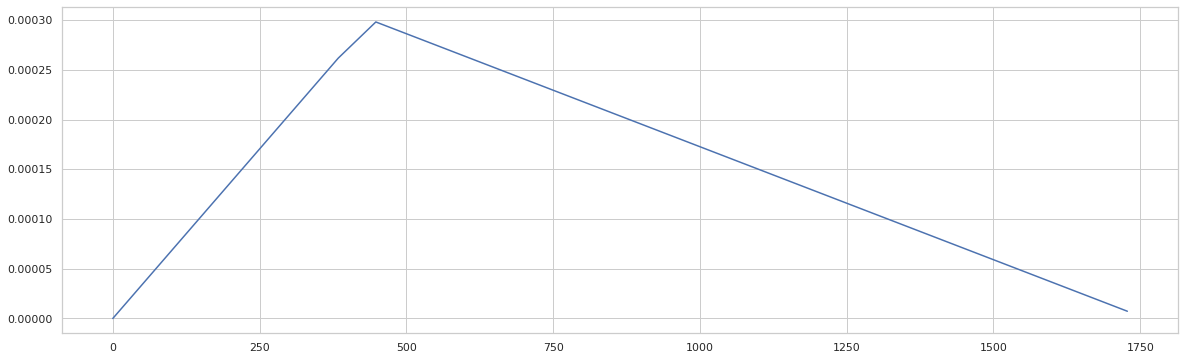

In [11]:
#@title
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch  = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch 
hold_max_steps = 0
warmup_steps = steps_per_epoch  * 5

rng = [i for i in range(0, total_steps, 64)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [13]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)
            
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.4.149.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.149.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


165232640/165226952 [==============================] - 3s 0us/step
Epoch 1/20
93/93 - 123s - loss: 0.5072 - auc: 0.5522 - val_loss: 0.3138 - val_auc: 0.7625
Epoch 2/20
93/93 - 94s - loss: 0.3041 - auc: 0.8227 - val_loss: 0.2984 - val_auc: 0.8285
Epoch 3/20
93/93 - 94s - loss: 0.2813 - auc: 0.8704 - val_loss: 0.2783 - val_auc: 0.8731
Epoch 4/20
93/93 - 94s - loss: 0.2657 - auc: 0.8953 - val_loss: 0.2659 - val_auc: 0.9032
Epoch 5/20
93/93 - 93s - loss: 0.2560 - auc: 0.9089 - val_loss: 0.2460 - val_auc: 0.9256
Epoch 6/20
93/93 - 94s - loss: 0.2470 - auc: 0.9192 - val_loss: 0.2412 - val_auc: 0.9315
Epoch 7/20
93/93 - 94s - loss: 0.2404 - auc: 0.9283 - val_loss: 0.2330 - val_auc: 0.9382
Epoch 8/20
93/93 - 94s - loss: 0.2323 - auc: 0.9354 - val_loss: 0.2272 - val_auc: 0.9444
Epoch 9/20
93/93 - 94s - loss: 0.2278 - auc: 0.9430 - val_loss: 0.2261 - val_auc: 0.9460
Epoch 10/20
93/93 - 95s - loss: 0.2197 - auc: 0.9499 - val_loss: 0.2194 - val_auc: 0.9476
Epoch 11/20
93/93 - 88s - loss: 0.2147 - 

INFO:tensorflow:Initializing the TPU system: grpc://10.4.149.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.149.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 123s - loss: 0.5128 - auc: 0.5515 - val_loss: 0.3190 - val_auc: 0.7958
Epoch 2/20
93/93 - 94s - loss: 0.3044 - auc: 0.8183 - val_loss: 0.2994 - val_auc: 0.8446
Epoch 3/20
93/93 - 94s - loss: 0.2807 - auc: 0.8684 - val_loss: 0.2814 - val_auc: 0.8863
Epoch 4/20
93/93 - 94s - loss: 0.2666 - auc: 0.8941 - val_loss: 0.2652 - val_auc: 0.9033
Epoch 5/20
93/93 - 94s - loss: 0.2583 - auc: 0.9059 - val_loss: 0.2527 - val_auc: 0.9233
Epoch 6/20
93/93 - 94s - loss: 0.2485 - auc: 0.9180 - val_loss: 0.2405 - val_auc: 0.9305
Epoch 7/20
93/93 - 94s - loss: 0.2393 - auc: 0.9282 - val_loss: 0.2332 - val_auc: 0.9353
Epoch 8/20
93/93 - 94s - loss: 0.2333 - auc: 0.9352 - val_loss: 0.2302 - val_auc: 0.9431
Epoch 9/20
93/93 - 94s - loss: 0.2286 - auc: 0.9403 - val_loss: 0.2291 - val_auc: 0.9421
Epoch 10/20
93/93 - 88s - loss: 0.2213 - auc: 0.9484 - val_loss: 0.2344 - val_auc: 0.9479
Epoch 11/20
93/93 - 88s - loss: 0.2153 - auc: 0.9536 - val_loss: 0.2291 - val_auc: 0.9453
Epoch 12/20
93/93 

INFO:tensorflow:Initializing the TPU system: grpc://10.4.149.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.149.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 124s - loss: 0.4842 - auc: 0.5656 - val_loss: 0.3264 - val_auc: 0.7567
Epoch 2/20
97/97 - 91s - loss: 0.2990 - auc: 0.8290 - val_loss: 0.3266 - val_auc: 0.8322
Epoch 3/20
97/97 - 97s - loss: 0.2780 - auc: 0.8759 - val_loss: 0.2981 - val_auc: 0.8713
Epoch 4/20
97/97 - 97s - loss: 0.2635 - auc: 0.8983 - val_loss: 0.2706 - val_auc: 0.9022
Epoch 5/20
97/97 - 97s - loss: 0.2532 - auc: 0.9103 - val_loss: 0.2501 - val_auc: 0.9239
Epoch 6/20
97/97 - 100s - loss: 0.2466 - auc: 0.9181 - val_loss: 0.2471 - val_auc: 0.9292
Epoch 7/20
97/97 - 97s - loss: 0.2365 - auc: 0.9321 - val_loss: 0.2384 - val_auc: 0.9369
Epoch 8/20
97/97 - 98s - loss: 0.2306 - auc: 0.9380 - val_loss: 0.2364 - val_auc: 0.9389
Epoch 9/20
97/97 - 97s - loss: 0.2234 - auc: 0.9445 - val_loss: 0.2300 - val_auc: 0.9434
Epoch 10/20
97/97 - 98s - loss: 0.2199 - auc: 0.9489 - val_loss: 0.2299 - val_auc: 0.9473
Epoch 11/20
97/97 - 98s - loss: 0.2114 - auc: 0.9547 - val_loss: 0.2259 - val_auc: 0.9472
Epoch 12/20
97/97

## Model loss graph

Fold: 1


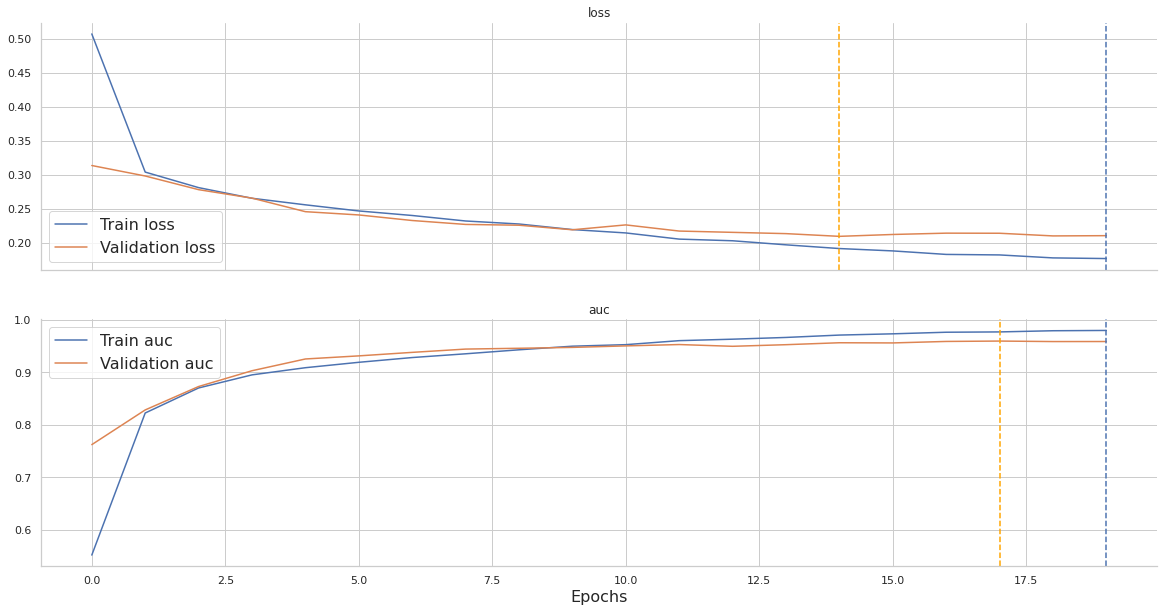

Fold: 2


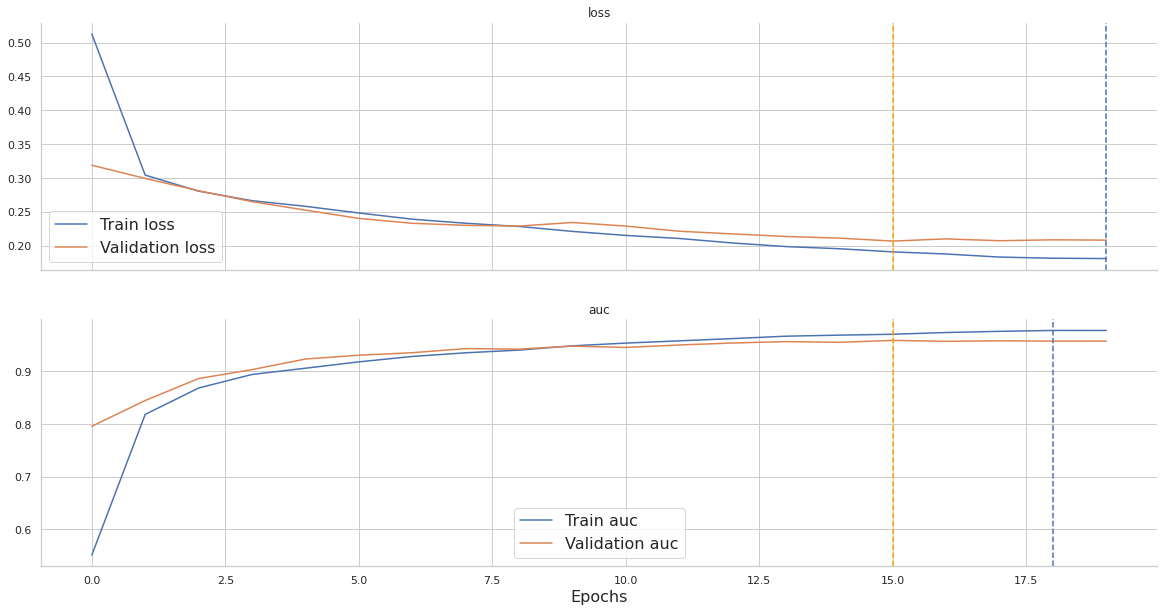

Fold: 3


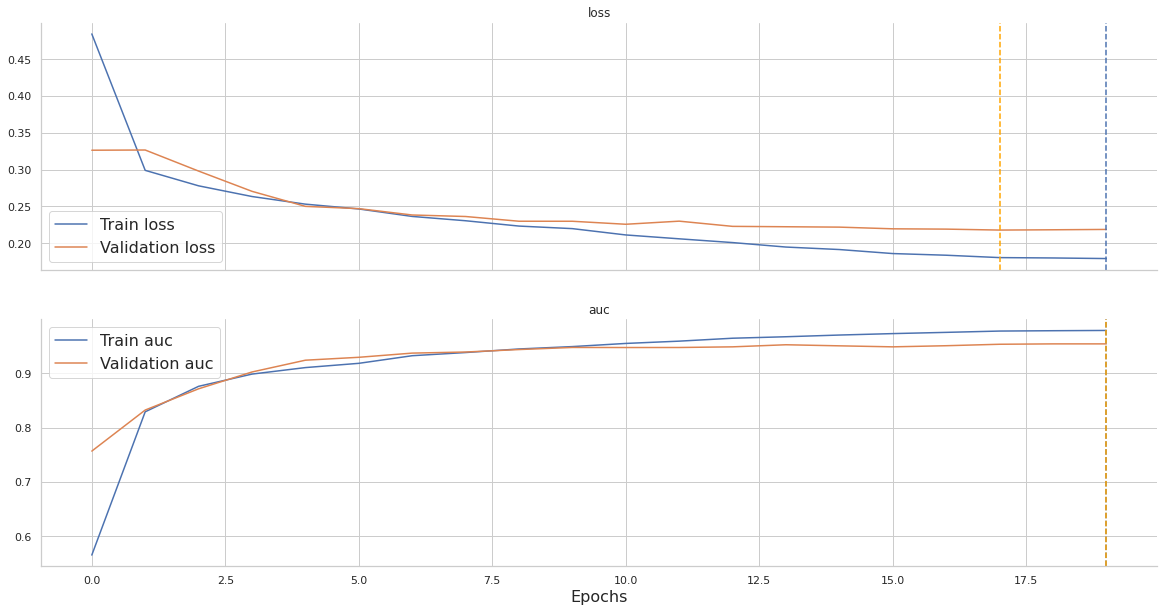

In [14]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

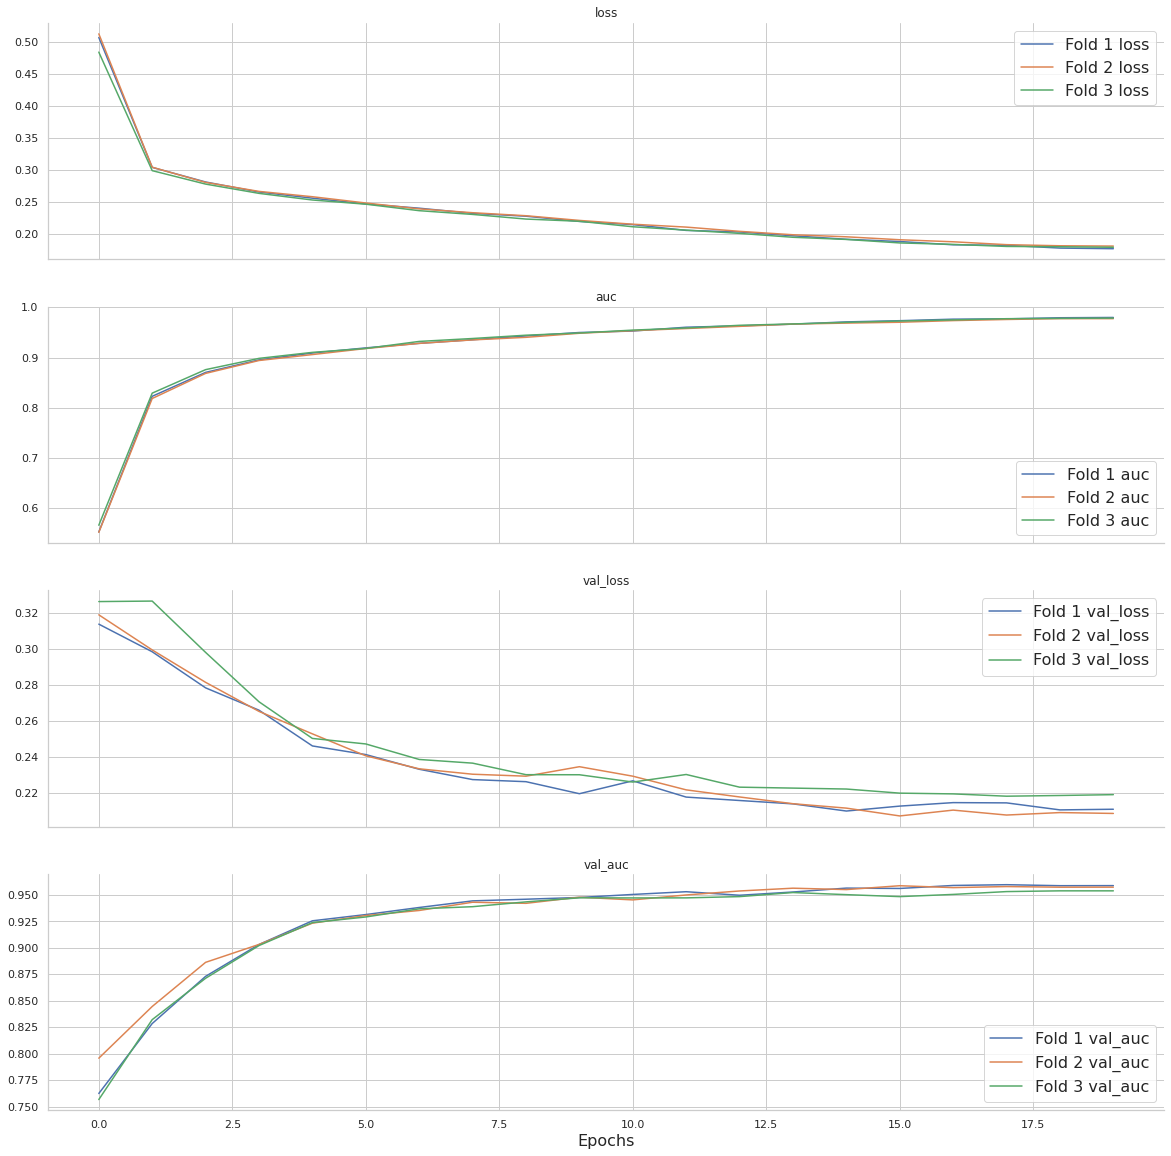

In [15]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [16]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.975926,0.902527,0.073399,0.977446,0.906047,0.975863,0.908382,0.974470,0.893153
Accuracy,0.991567,0.980018,0.011550,0.991698,0.982212,0.991305,0.979529,0.991699,0.978312
Precision,0.865736,0.401463,0.464273,0.852459,0.417722,0.879479,0.386667,0.865269,0.400000
Recall,0.617799,0.263910,0.353889,0.654088,0.308411,0.584416,0.237705,0.614894,0.245614
F1-score,0.720443,0.317868,0.402576,0.740214,0.354839,0.702211,0.294416,0.718905,0.304348
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [17]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.975926,0.902527,0.073399,0.977446,0.906047,0.975863,0.908382,0.974470,0.893153
male,0.977755,0.902961,0.074794,0.980129,0.918596,0.977995,0.908876,0.975142,0.881412
female,0.972796,0.900248,0.072548,0.972828,0.881174,0.972099,0.904972,0.973461,0.914599
head/neck,0.989837,0.892108,0.097729,0.988812,0.926833,0.989977,0.854562,0.990723,0.894930
upper extremity,0.971791,0.886287,0.085505,0.969065,0.912871,0.974463,0.878378,0.971847,0.867610
lower extremity,0.965914,0.874143,0.091771,0.966864,0.886729,0.964389,0.862440,0.966488,0.873260
torso,0.978332,0.925961,0.052371,0.981832,0.900995,0.978106,0.943911,0.975059,0.932977
0 <= age < 26,0.969394,0.895664,0.073729,0.972481,0.966304,0.982469,0.751708,0.953232,0.968981
26 <= age < 40,0.968301,0.874681,0.093619,0.984232,0.792878,0.967586,0.904660,0.953084,0.926506


# Model evaluation (best)

In [18]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.973873,0.903858,0.070015,0.973702,0.905631,0.973237,0.912928,0.974679,0.893015
Accuracy,0.990819,0.981729,0.009091,0.990523,0.984583,0.990090,0.981443,0.991845,0.979160
Precision,0.878020,0.476923,0.401097,0.901060,0.533333,0.852632,0.466667,0.880368,0.430769
Recall,0.557068,0.233140,0.323927,0.534591,0.224299,0.525974,0.229508,0.610638,0.245614
F1-score,0.680920,0.312110,0.368810,0.671053,0.315789,0.650602,0.307692,0.721106,0.312849
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.973873,0.903858,0.070015,0.973702,0.905631,0.973237,0.912928,0.974679,0.893015
male,0.975977,0.905401,0.070576,0.977195,0.925138,0.975505,0.909327,0.975231,0.881737
female,0.970223,0.899180,0.071043,0.967862,0.868246,0.968960,0.916135,0.973847,0.913157
head/neck,0.988105,0.894192,0.093913,0.986916,0.923610,0.986604,0.868293,0.990795,0.890673
upper extremity,0.971354,0.884705,0.086649,0.969305,0.913517,0.973037,0.872011,0.971719,0.868587
lower extremity,0.962988,0.872711,0.090278,0.960840,0.875426,0.961392,0.870894,0.966734,0.871813
torso,0.976232,0.928375,0.047857,0.977306,0.905265,0.976063,0.945777,0.975326,0.934082
0 <= age < 26,0.966067,0.887402,0.078665,0.969239,0.956522,0.976454,0.735314,0.952509,0.970370
26 <= age < 40,0.967156,0.877381,0.089775,0.979676,0.786579,0.968818,0.916430,0.952975,0.929135


# Confusion matrix

Fold: 1


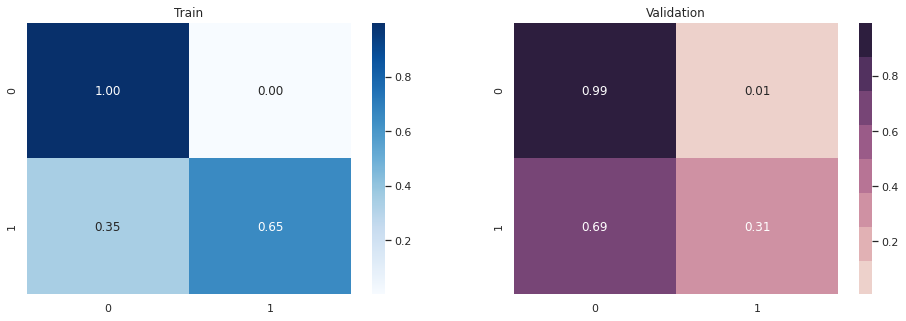

Fold: 2


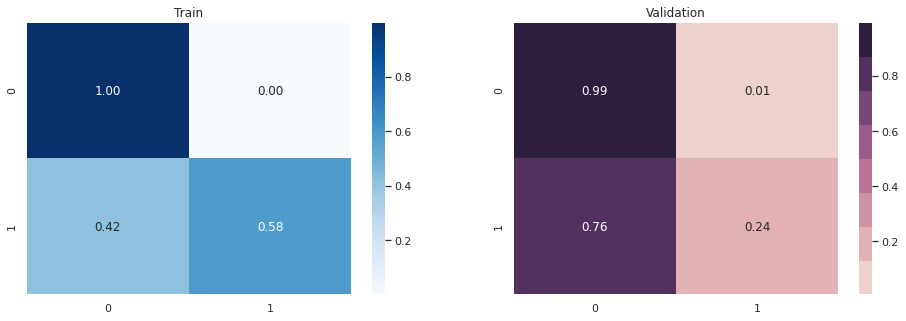

Fold: 3


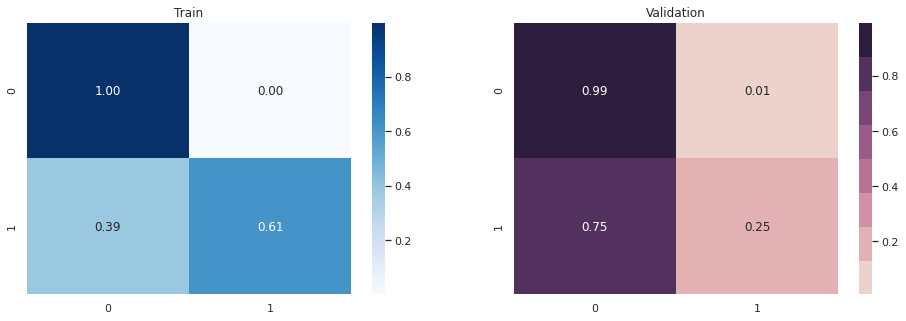

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 189
Train positive correct predictions: 185
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.017600,0.030582,0.025888,0.031527
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.014443,0.023563,0.024845,0.023805
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.014429,0.023740,0.022111,0.026294
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.017958,0.034163,0.025508,0.030119
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.014711,0.023136,0.025617,0.024800
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.020129,0.044359,0.027410,0.028875
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.015451,0.023669,0.028442,0.025146
7,ISIC_0075663,female,35.0,torso,unknown,0,0.015286,0.025558,0.024632,0.026240
8,ISIC_0075914,male,30.0,torso,unknown,0,0.017561,0.026465,0.028115,0.033223
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.018326,0.029576,0.026980,0.035076


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.016154,0.024577,0.028435,0.027760
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.357050,0.869772,0.059744,0.855735
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.153137,0.705389,0.024706,0.035588
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.318324,0.815843,0.468941,0.306836
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.540259,0.920163,0.929827,0.851303
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.578576,0.946899,0.972190,0.973791
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.029102,0.056134,0.045966,0.043409
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.357863,0.423772,0.890782,0.474763
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.500571,0.776033,0.951574,0.775248
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.183514,0.851461,0.039419,0.026691


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.540259,0.920163,0.929827,0.851303
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.578576,0.946899,0.972190,0.973791
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.500571,0.776033,0.951574,0.775248
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.590875,0.985399,0.985394,0.983584
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.519873,0.789568,0.931630,0.878168
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.586189,0.982526,0.978275,0.970146
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.568983,0.922094,0.963962,0.958860
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.530477,0.929998,0.847363,0.875024
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.587235,0.981265,0.973483,0.981426
2143,ISIC_0744013,female,65.0,upper extremity,melanoma,1,0.571758,0.919761,0.966906,0.972125


# Visualize test predictions

In [21]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 115|10867
Test predictions (last) 153|10829
Test predictions (tta) 111|10871
Test predictions (last tta) 130|10852
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.023896,0.024108,0.023702,0.023724
1,ISIC_0052349,male,40.0,lower extremity,0.024311,0.024439,0.025351,0.024388
2,ISIC_0058510,female,55.0,torso,0.026222,0.025034,0.025902,0.025166
3,ISIC_0073313,female,50.0,torso,0.023704,0.023770,0.023202,0.023852
4,ISIC_0073502,female,45.0,lower extremity,0.026681,0.025572,0.027102,0.026619
5,ISIC_0074618,male,50.0,lower extremity,0.037134,0.034823,0.036944,0.036770
6,ISIC_0076801,male,45.0,upper extremity,0.026595,0.027131,0.025402,0.024912
7,ISIC_0077586,male,50.0,lower extremity,0.038974,0.036385,0.047284,0.034364
8,ISIC_0082004,female,45.0,torso,0.028646,0.026673,0.031933,0.029181
9,ISIC_0082785,male,65.0,lower extremity,0.026852,0.026669,0.026564,0.026128


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.561942,0.624333,0.509964,0.620819
42,ISIC_0155983,male,70.0,torso,0.634450,0.722155,0.594787,0.725913
102,ISIC_0208233,female,60.0,lower extremity,0.981055,0.984930,0.950476,0.969308
109,ISIC_0216447,male,80.0,head/neck,0.753712,0.798519,0.538916,0.640793
296,ISIC_0391046,male,85.0,torso,0.638495,0.677748,0.765571,0.785071
471,ISIC_0539432,female,45.0,lower extremity,0.510652,0.609329,0.722746,0.856812
530,ISIC_0588352,male,60.0,lower extremity,0.652001,0.946850,0.673292,0.786050
552,ISIC_0606244,male,70.0,torso,0.662403,0.740545,0.722607,0.600136
596,ISIC_0637104,female,80.0,torso,0.705416,0.668652,0.670898,0.687046
764,ISIC_0775584,female,35.0,lower extremity,0.598009,0.676317,0.442397,0.587277


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.561942,0.624333,0.509964,0.620819
42,ISIC_0155983,male,70.0,torso,0.634450,0.722155,0.594787,0.725913
102,ISIC_0208233,female,60.0,lower extremity,0.981055,0.984930,0.950476,0.969308
109,ISIC_0216447,male,80.0,head/neck,0.753712,0.798519,0.538916,0.640793
296,ISIC_0391046,male,85.0,torso,0.638495,0.677748,0.765571,0.785071
403,ISIC_0481105,male,80.0,torso,0.448163,0.551518,0.449952,0.549037
417,ISIC_0495887,male,65.0,torso,0.192040,0.556383,0.115126,0.393838
471,ISIC_0539432,female,45.0,lower extremity,0.510652,0.609329,0.722746,0.856812
530,ISIC_0588352,male,60.0,lower extremity,0.652001,0.946850,0.673292,0.786050
552,ISIC_0606244,male,70.0,torso,0.662403,0.740545,0.722607,0.600136


# Test set predictions

In [22]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.023896,0.024108,0.024002,0.023702,0.023724,0.023713
1,ISIC_0052349,0.024311,0.024439,0.024375,0.025351,0.024388,0.024870
2,ISIC_0058510,0.026222,0.025034,0.025628,0.025902,0.025166,0.025534
3,ISIC_0073313,0.023704,0.023770,0.023737,0.023202,0.023852,0.023527
4,ISIC_0073502,0.026681,0.025572,0.026126,0.027102,0.026619,0.026860
5,ISIC_0074618,0.037134,0.034823,0.035978,0.036944,0.036770,0.036857
6,ISIC_0076801,0.026595,0.027131,0.026863,0.025402,0.024912,0.025157
7,ISIC_0077586,0.038974,0.036385,0.037679,0.047284,0.034364,0.040824
8,ISIC_0082004,0.028646,0.026673,0.027659,0.031933,0.029181,0.030557
9,ISIC_0082785,0.026852,0.026669,0.026760,0.026564,0.026128,0.026346


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.045981,0.049397,0.047689,0.046903,0.049019,0.047961
std,0.087102,0.096719,0.091531,0.084782,0.090914,0.087450
min,0.020963,0.021398,0.021188,0.021460,0.021250,0.021710
25%,0.024698,0.024680,0.024705,0.024873,0.024862,0.024870
50%,0.027493,0.027192,0.027340,0.027829,0.027469,0.027689
75%,0.034191,0.034397,0.034443,0.035177,0.035184,0.035375
max,0.981055,0.984930,0.982993,0.978704,0.983172,0.980938
